In [2]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
from sklearn.neighbors import KernelDensity
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [3]:
with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    print(file["Events"].keys())

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']


In [4]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)
        
def add_angle(arr):
    part=get_vector(arr)
    arr["theta"] = part.theta*(180/np.pi)-90
    return 

def add_momentum(arr):
    rho = np.sqrt(arr.px**2+arr.py**2+arr.pz**2)
    arr["momentum"] = rho
    return

#Returns ak.Record with coffea.LorentzVector behavior
def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part 
def kernelDensity(arr):
    match=np.zeros(ak.num(arr, axis=0))
    spot=0
    for evt in arr:
        if len(evt)==1:
            match[spot]=evt[0]
            spot+=1
            continue
        kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(evt[:, np.newaxis])
        dens = np.exp(kde.score_samples(evt[:, np.newaxis]))
        mostLikely=max(dens)
        for i in range(len(dens)):
            if dens[i]==mostLikely: 
                match[spot]=evt[i]
                break
        spot+=1
    
    return match
    



In [5]:
histsAdd={}

#-----------------------------------------------------------------------------------------------------------------------
#----------------------------------- Additional Histograms -------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------- 
#-----------Sim_Particle
histsAdd["simParticle_theta"]=hist.Hist("Sim_Particle Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sim_Particle Theta (Radians)", 100, 0, 3.5),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))


#-----------Recoil_SimHit

histsAdd["recoil_sumEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Energy Deposited [MeV]", 100, 0, 2.5),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["recoil_avgEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited [MeV]", 100, 0, 1.5),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

#--Some New Recoil Tracker Specific Attributes
histsAdd["recoil_numHits"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Number of Hits in Event", 15, 0, 15)))

histsAdd["recoil_thetaLayer"]=hist.Hist("Sim Particles", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Sim_Particle Theta (Degrees)", 100, -90, 90),
                            hist.Bin("s", "Furthest Layer Hit", 10, 1, 11)))

histsAdd["recoil_thetaLayerAll"]=hist.Hist("Sim Particles", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Sim_Particle Theta (Degrees)", 100, -90, 90),
                            hist.Bin("s", "Layers Hit", 10, 1, 11)))

histsAdd["recoil_mostProbable"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Most Probable Energy Loss of Event", 100, 0, 1),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

#-----------Ecal_SimHit

histsAdd["ecalSim_sumEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Energy Deposited in Event [MeV]", 100, 0, 10.0),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalSim_avgEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited in Event [MeV]", 100, 0, 1.0),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalSim_eOverP"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of dE/dz of Particle Over Momentum of Particle", 100, 0, 0.015),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalSim_eMinusP"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of dE/dz of Particle Minus Momentum of Particle", 100, -3000, 100),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalSim_showerRMSWidth"]=hist.Hist("Ecal_SimHit Events", axes=( #Take the RMS of all x, y hits? or per layer and add? 
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "RMS of Shower Width [mm]", 100, 0, 300),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalSim_mostProbable"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Most Probable Energy Loss of Event", 100, 0, 1),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

#----------Ecal_RecHit
histsAdd["ecalRec_sumDedz"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of dE/dz in Event [MeV]", 100, 0, 500),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_avgDedz"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average of dE/dz in Event [MeV]", 100, 0, 25),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_sumE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Hit Energies in Event [MeV]", 100, 0, 1000),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_avgE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Hit Energy in Event [MeV]", 100, 0, 50),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_sumAmp"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of Hit Amplitudes in Event [MeV]", 100, 0, 10.0),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_avgAmp"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Hit Amplitude in Event [MeV]", 100, 0, 0.8),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_eOverP"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of dE/dz of Particle Over Momentum of Particle", 100, 0, 0.3),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_eMinusP"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sum of dE/dz of Particle Minus Momentum of Particle", 100, -3000, 100),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_showerRMSWidth"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "RMS of Shower Width [mm]", 100, 0, 300),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))

histsAdd["ecalRec_mostProbable"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Most Probable Energy Loss of Event", 100, 0, 13),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000])))


In [16]:
def ProcessChunk(chunk):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']
    
    #print(ak.to_list(ecal_rechit.layer[0:20]),'\n',ak.to_list(ecal_rechit.e[0:20]),'\n',ak.to_list(sim_particle.kine[0:20]))


#------------------------------------------------------------------------------------------------------------    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
#------------------------------------------------------------------------------------------------------------    
    #Determines Kinetic Energy
    parKine=""
    if ak.all(sim_particle.kine==100):
        parKine=100
    elif ak.all(sim_particle.kine==500):
        parKine=500
    elif ak.all(sim_particle.kine==1000):
        parKine=1000
    elif (ak.all(sim_particle.kine==2000)):
        parKine=2000
        return
    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
            
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #Scatter Masks
    #recoilPath=dontlookback(recoil_simhit.layer, recoilIDMask)
    #ecalPath=dontlookback(ecal_simhit.layer, Start=-1)
    #ecalRecPath=dontlookback(ecal_rechit.layer, Start=-1)

    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #dE/dz for variious data sets
    recoilSiWidth=0.32
    ecalSiWidth=0.5
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    
    #'''
    #NEW ATTRIBUTES ADDED TO SIM_PARTICLES
    add_angle(sim_particle)
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_RECHITS
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    
    ecal_rechit["dedz"]=ecal_rechit.e/widthMap
    #'''
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #------------------------------------Data Anlaysis/Histogram Filling------------------------------------------------
    
    #---------------Sim Particle
    
    
    #---------------Recoil Tracker
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=recoilMIPMask & recoilIDMask
    emptiesIncluded=recoil_simhit[twoDMask]
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    noEmpties=ak.flatten(prepared, axis=0)


    #Fills Energy Sum and Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)

    histsAdd["recoil_sumEdep"].fill(particle=par, kine=parKine, e=edepSum)
    histsAdd["recoil_avgEdep"].fill(particle=par, kine=parKine, e=edepAvg)

    #Fills Number of Hits
    numh=ak.flatten(ak.num(noEmpties.layer, axis=1), axis=None)
    histsAdd["recoil_numHits"].fill(particle=par, e=numh,  kine=parKine)

    #Fills Depth
    depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
    #print(ak.to_list(depthMax)[0:100])
    #histsAdd["recoil_depth"].fill(particle=par, e=depthMax, s=i)
    
    #Fills Theta and ThetaLayer
    theta=ak.flatten(sim_particle.theta, axis=None)
    sameAlign=(sim_particle[recoilEmptyMask])[emptiesMask]
    thetaL=ak.flatten(sameAlign.theta, axis=None)
    
    print(ak.flatten(sameAlign.theta[ak.max(noEmpties.layer)==1], axis=None))
    print(ak.flatten(noEmpties.layer[ak.max(noEmpties.layer)==1], axis=None))
    
    thetaLL, allLayers=ak.broadcast_arrays(thetaL, noEmpties.layer)
    allLayers=ak.flatten(allLayers, axis=None)
    thetaLL=ak.flatten(thetaLL, axis=None)
    theta=ak.flatten(np.sqrt(noEmpties.x**2+noEmpties.y**2), axis=None)

    histsAdd["simParticle_theta"].fill(particle=par, e=theta, kine=parKine)
    histsAdd["recoil_thetaLayer"].fill(particle=par, e=thetaL, s=depthMax, kine=parKine)
    histsAdd["recoil_thetaLayerAll"].fill(particle=par, e=thetaLL, s=allLayers, kine=parKine)

    #'''    
    #Fills Most Probable Energy Loss
    mostProb=kernelDensity(noEmpties.dedz)

    histsAdd["recoil_mostProbable"].fill(particle=par, e=mostProb, kine=parKine)
    ''' 
    print("Recoil Done")
    #'''
    #---------------Ecal_SimHits
    '''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalSimMIPMask
    emptiesIncluded=ecal_simhit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    noEmpties=ak.flatten(prepared, axis=0)
    
    #For Momentum of Particle
    #Okay to have empty events in recoil (will be converted to None later), as long as it is aligned
    #1-EcalEmptyMask, now same alignment with ecal_simhit. 2-ak.mask(emptiesMask), same alignment as prepared 
    momRecoil=ldmx_events['Recoil_SimHit']
    add_momentum(momRecoil)
    momentums=ak.mask(momRecoil[ecalEmptyMask], emptiesMask)

    
    #Fills Energy Sum and Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)

    histsAdd["ecalSim_sumEdep"].fill(particle=par, e=edepSum, kine=parKine)
    histsAdd["ecalSim_avgEdep"].fill(particle=par, e=edepAvg, kine=parKine)

    #Fills Shower RMS Width
    R2=noEmpties.x**2+noEmpties.y**2
    rms=np.sqrt(ak.sum(R2, axis=1)/ak.num(R2, axis=1))

    histsAdd["ecalSim_showerRMSWidth"].fill(particle=par, e=rms, kine=parKine)

    #Fills Energy over Momentum and Energy minus Momentum
    #3- apply oneDMask, same ali. as noEmpties now. 4- ak.mask empty lists, ready for division AND subtraction. 
    moments=ak.flatten(momentums[oneDMask], axis=0)
    moments=ak.mask(moments, ak.num(moments)>0)
    eOverP=ak.flatten(ak.sum(noEmpties.edep, axis=1)/moments.momentum[:,-1], axis=None)
    eMinusP=ak.flatten(ak.sum(noEmpties.edep, axis=1)-moments.momentum[:,-1], axis=None)

    histsAdd["ecalSim_eOverP"].fill(particle=par, e=eOverP, kine=parKine)
    histsAdd["ecalSim_eMinusP"].fill(particle=par, e=eMinusP, kine=parKine)

    #Fills Most Probable Energy Loss
    mostProb=kernelDensity(noEmpties.dedz)

    histsAdd["ecalSim_mostProbable"].fill(particle=par, e=mostProb, kine=parKine)  
        
    print("Ecal SimHit Done")
    #'''
    #---------------Ecal_RecHits
    '''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalRecMIPMask
    emptiesIncluded=ecal_rechit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    noEmpties=ak.flatten(prepared, axis=0)
    
    #For Momentum of Particle
    momRecoil=ldmx_events['Recoil_SimHit']
    add_momentum(momRecoil)
    momentums=ak.mask(momRecoil[ecalRecEmptyMask], emptiesMask)
    
    
    #Fills Sum, Average dedz 
    sumdedz=ak.flatten(ak.sum(noEmpties.dedz, axis=1), axis=None)
    avgdedz=ak.flatten(ak.mean(noEmpties.dedz, axis=1), axis=None)

    histsAdd["ecalRec_sumDedz"].fill(particle=par, e=sumdedz, kine=parKine)
    histsAdd["ecalRec_avgDedz"].fill(particle=par, e=avgdedz, kine=parKine)

    #Fills Sum, Average Energy
    sumE=ak.flatten(ak.sum(noEmpties.e, axis=1), axis=None)
    avgE=ak.flatten(ak.mean(noEmpties.e, axis=1), axis=None)

    histsAdd["ecalRec_sumE"].fill(particle=par, e=sumE, kine=parKine)
    histsAdd["ecalRec_avgE"].fill(particle=par, e=avgE, kine=parKine)

    #Fills Sum, Average Amplitude
    sumAmp=ak.flatten(ak.sum(noEmpties.amp, axis=1), axis=None)
    avgAmp=ak.flatten(ak.mean(noEmpties.amp, axis=1), axis=None)

    histsAdd["ecalRec_sumAmp"].fill(particle=par, e=sumAmp, kine=parKine)
    histsAdd["ecalRec_avgAmp"].fill(particle=par, e=avgAmp, kine=parKine)

    #Fills Shower RMS Width
    R2=noEmpties.x**2+noEmpties.y**2
    rms=np.sqrt(ak.sum(R2, axis=1)/ak.num(R2, axis=1))

    histsAdd["ecalRec_showerRMSWidth"].fill(particle=par, e=rms, kine=parKine)

    #Fills Energy over Momentum and Energy minus Momentum
    moments=ak.flatten(momentums[oneDMask], axis=0)
    moments=ak.mask(moments, ak.num(moments)>0)
    eOverP=ak.flatten(ak.sum(noEmpties.dedz, axis=1)/moments.momentum[:,-1], axis=None)
    eMinusP=ak.flatten(ak.sum(noEmpties.dedz, axis=1)-moments.momentum[:,-1], axis=None)

    histsAdd["ecalRec_eOverP"].fill(particle=par, e=eOverP, kine=parKine)
    histsAdd["ecalRec_eMinusP"].fill(particle=par, e=eMinusP, kine=parKine)

    #Fills Most Probable Energy Loss
    mostProb=kernelDensity(noEmpties.dedz)

    histsAdd["ecalRec_mostProbable"].fill(particle=par, e=mostProb, kine=parKine)
        
    print("Ecal RecHit Done")
    #'''
    #------------------------------------------------------------------------------------------

In [17]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Sep30/*.root")

start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk)
    
stop=process_time()
print("Elapsed time during the whole program in seconds:", stop-start) 

process 1


C:\Users\Acer\anaconda3\lib\site-packages\awkward\highlevel.py:996: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  tmp = ak._util.wrap(self.layout[where], self._behavior)


[-90]
[1, 5, 6, 8, 9]
Recoil Done
process 2
[-90]
[1, 5]
Recoil Done
process 3
[-90]
[1, 5]
Recoil Done
process 4
process 5
[-90]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Recoil Done
process 6
[-90]
[1, 2, 3, 4, 6, 7, 8, 9, 10]
Recoil Done
process 7
[-90]
[1, 7, 9]
Recoil Done
process 8
Elapsed time during the whole program in seconds: 25.578125


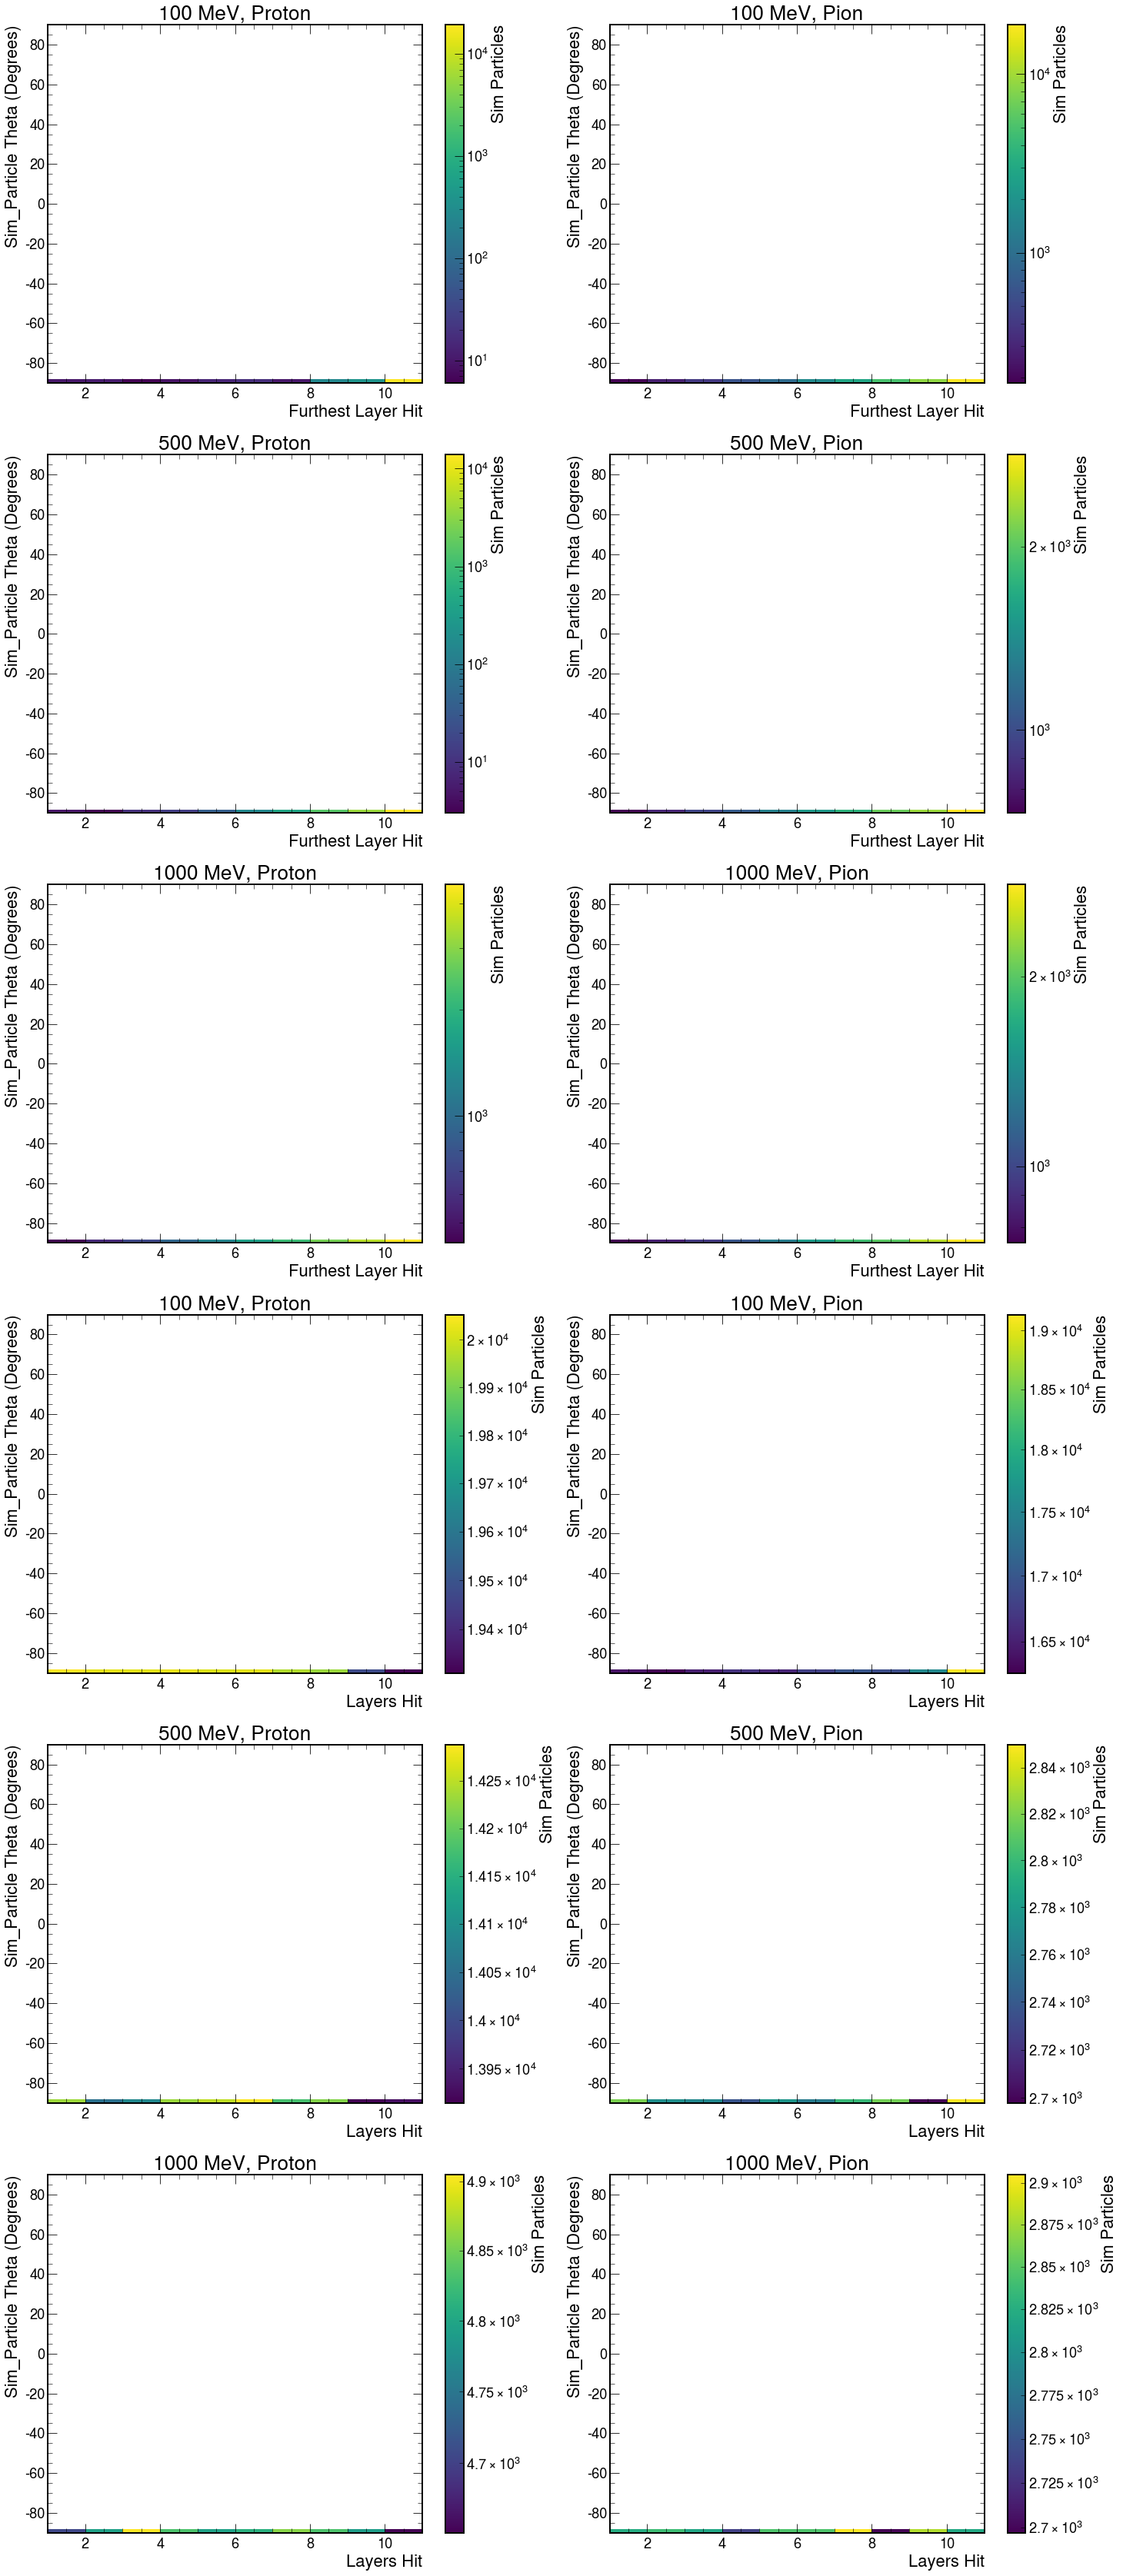

In [11]:
import ipywidgets as widgets
%matplotlib inline
from matplotlib import rcParams
from matplotlib import colors
plt.rcParams.update({'font.size': 22})


#------------------------ Plotting Functions ----------------------------------

#'''
def oneDPlot(names):
    numP=len(names)
    fig, ax=plt.subplots(ncols=3, nrows=numP, figsize=(36, 10*numP))
    for i in range(0, numP):
            hist.plot1d(histsAdd[names[i]][:, 100].sum("kine"),ax=ax[i, 0], clear=True, overlay="particle")
            ax[i, 0].set_title("100 MeV")
            hist.plot1d(histsAdd[names[i]][:, 500].sum("kine"), ax=ax[i, 1], clear=True, overlay="particle")
            ax[i, 1].set_title("500 MeV")
            hist.plot1d(histsAdd[names[i]][:, 1000].sum("kine"), ax=ax[i, 2], clear=True, overlay="particle")
            ax[i, 2].set_title("1000 MeV")
            


def twoDPlot(names):
    numP=len(names)*3
    fig, ax=plt.subplots(ncols=2, nrows=numP, figsize=(24, 10*numP))
    for i in range(0, numP//3):
        hist.plot2d(histsAdd[names[i]]["Proton", 100].sum("particle").sum("kine"), "s", ax=ax[i*3,0], clear=True, patch_opts={'norm': colors.LogNorm()})
        hist.plot2d(histsAdd[names[i]]["Pion", 100].sum("particle").sum("kine"), "s", ax=ax[i*3,1], clear=True, patch_opts={'norm': colors.LogNorm()})
        ax[i*3, 0].set_title("100 MeV, Proton")
        ax[i*3, 1].set_title("100 MeV, Pion")

        hist.plot2d(histsAdd[names[i]]["Proton", 500].sum("particle").sum("kine"), "s", ax=ax[i*3+1,0], clear=True, patch_opts={'norm': colors.LogNorm()})
        hist.plot2d(histsAdd[names[i]]["Pion", 500].sum("particle").sum("kine"), "s", ax=ax[i*3+1,1], clear=True, patch_opts={'norm': colors.LogNorm()})
        ax[i*3+1, 0].set_title("500 MeV, Proton")
        ax[i*3+1, 1].set_title("500 MeV, Pion")

        hist.plot2d(histsAdd[names[i]]["Proton", 1000].sum("particle").sum("kine"), "s", ax=ax[i*3+2,0], clear=True, patch_opts={'norm': colors.LogNorm()})
        hist.plot2d(histsAdd[names[i]]["Pion", 1000].sum("particle").sum("kine"), "s", ax=ax[i*3+2,1], clear=True, patch_opts={'norm': colors.LogNorm()})
        ax[i*3+2, 0].set_title("1000 MeV, Proton")
        ax[i*3+2, 1].set_title("1000 MeV, Pion")
#'''

#------------------------------------- Plots ---------------------------------------------------

#--------------------------------------------------------------------------------------------------
#              All graphs have a MIP mask on them, all dEdz graphs currently lack a dz
#--------------------------------------------------------------------------------------------------
#'''
oneDNames=np.array(["simParticle_theta",
                "recoil_sumEdep", "recoil_avgEdep", "recoil_numHits", "recoil_mostProbable", "recoil_mpelMinusP", 
                "ecalSim_sumEdep", "ecalSim_avgEdep", "ecalSim_eOverP", "ecalSim_eMinusP",
                "ecalSim_showerRMSWidth", "ecalSim_mostProbable",
                "ecalRec_sumDedz", "ecalRec_avgDedz", "ecalRec_sumE", "ecalRec_avgE", "ecalRec_sumAmp", 
                "ecalRec_avgAmp", "ecalRec_eOverP", "ecalRec_eMinusP",
                "ecalRec_showerRMSWidth", "ecalRec_mostProbable", "ecalRec_mpelMinusP"])

twoDNames=np.array(['recoil_dedzMIPLayer', "recoil_residualMax", "recoil_residualLast", \
       'ecalSim_dedzMIPLayer', "ecalSim_residualMax", "ecalSim_residualLast",\
       'ecalRec_dedzMIPLayer', "ecalRec_residualMax", "ecalRec_residualLast"])

#twoDPlot(twoDNames)
#oneDPlot(oneDNames)
#hist.plot2d(histsAdd["recoil_thetaLayer"]["Proton"].sum("particle").sum("kine"), "s")
twoDPlot(["recoil_thetaLayer", "recoil_thetaLayerAll"])
#oneDPlot(["recoil_mostProbable", "recoil_mostProbable"])

#print(histsAdd["recoil_thetaLayer"][:,100].values())
plt.show()

In [ ]:
"""
#------------------------------------------------------------------------------------------------------
#----------------------------------ROC Curves----------------------------------------------------------
#------------------------------------------------------------------------------------------------------
from sklearn import metrics

piondedz=histsAdd['ecalSim_dedzKine'].values()[('Pion',)]
protondedz=histsAdd['ecalSim_dedzKine'].values()[('Proton',)]
#print(piondedz)
#print(protondedz)


#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)
#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))
#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the
#y_score, and sample_weights=targetWeights

#Creates y_true binary array
def parLabel(arr, pdgID):
    return [pdgID for x in arr]

#tacks on arr2 to arr1 at the innermost dimension
def merge(arr1, arr2):
    return np.append(arr1, arr2, axis=-1)
    

#Generates ROC curves given 2d histogram arrays for proton and pion.
def ROCKdat(proton, pion, lower, upper):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigscore=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigweights=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    step=upper/arrsize
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        #Check This
        if (all(proWeights[i:]==0)):
            proton_prob=0.000001
        else:
            proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    #print(bigtrue)
    return bigtrue, bigscore, bigweights
                                    
    
#For 2d histogram arrays, the rows are the de/dz, the columns are kine. 
def threeROC(histogram, numROC, fig, upper):
    proton=histogram.values()[('Proton',)]
    pion=histogram.values()[('Pion',)]
    kinesize=len(proton)
    step=kinesize/numROC
    
    for i in np.linspace(step, kinesize, numROC):
        lo=math.floor(i-step)
        up=math.floor(i)
        ytru, ysco, weig=ROCKdat(np.ndarray.flatten(proton[:, lo:up]), np.ndarray.flatten(pion[:, lo:up]), 0, upper)
        fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)
        plt.plot(fpr, tpr, figure=fig, label="{}-{}GeV".format(0.1+round((i-step)*0.019, 3), round(0.1+i*0.019, 3)))
    
    
    
#'''  
fig1, ax1=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalSim_dedzKine"], 5, fig1, 0.2) 
plt.plot([0,1],[0,1],"--", figure=fig1, label="Random Classifier")
fig1.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Recoil tracker, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig1.suptitle(title, ha='center', y=0.05, fontsize=14)
ax1.set_ylabel("TPR")
ax1.set_xlabel("FPR")
#'''

#'''
fig2, ax2=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["recoil_dedzKine"], 5, fig2, 0.2)
plt.plot([0,1],[0,1],"--", figure=fig2, label="Random Classifier")
fig2.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal SimHit, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig2.suptitle(title, ha='center', y=0.05, fontsize=14)
ax2.set_ylabel("TPR")
ax2.set_xlabel("FPR")
#'''

#'''
fig3, ax3=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalRec_avgAmpKine"], 5, fig3, 0.8)
plt.plot([0,1],[0,1],"--", figure=fig3, label="Random Classifier")
fig3.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal RecHit, Event Average Amplitude vs Kinetic Energy classification, TPR for Protons"
fig3.suptitle(title, ha='center', y=0.05, fontsize=14)
ax3.set_ylabel("TPR")
ax3.set_xlabel("FPR")
#'''    
    
#ytru, ysco, weig= ROCKdat(protondedz, piondedz, 0, 0.30)
#fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)

#fig2, ax2=plt.subplots()
#plt.plot(fpr, tpr, figure=fig2)
"""